In [1]:
%load_ext autoreload
%autoreload 2

In [167]:
from HelperClasses import ClassificationModel, DataHandler, UCRDataset
from pyts.datasets import fetch_ucr_dataset
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import MinMaxScaler
import sklearn
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from tslearn.shapelets import LearningShapelets

In [49]:
def scale_dataset(traindata, testdata):
    minmaxscaler = MinMaxScaler()
    minmaxscaler.fit(traindata.reshape(-1, 1))

    scaled_traindata = minmaxscaler.transform(traindata.reshape(-1, 1)).reshape(-1, traindata.shape[1], 1)
    scaled_testdata = minmaxscaler.transform(testdata.reshape(-1, 1)).reshape(-1, testdata.shape[1], 1)
    return scaled_traindata, scaled_testdata


def getAreasFromGradCam(gradcam0, gradcam1, threshold):
    gradcam = np.fmax(gradcam0, gradcam1)
    above_threshold = gradcam > threshold
    areas = []
    start = None
    end = None
    for i, j in enumerate(above_threshold):
        if j & (start is None):
            start = i
        if (not j) & (start is not None):
            end = i
            areas.append([start, end])
            start = None
            end = None
    if start is not None:
        areas.append([start, len(above_threshold)])
    return areas


def getAreasFromLearningShapelets(locations, shapelets):
    return [[[location, location + length] for location, length in zip(sample_locations, [len(s) for s in shapelets])] for sample_locations in locations]


def plot_ts(ts_sample):
    ts, label = ts_sample
    plt.figure(figsize=(10, 4))
    plt.plot(ts, label="Time Series", color='blue')
    plt.title(f"Time Series Plot (Class Label: {label})")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()

In [4]:
datasets = [{"name": "GunPoint", 1: "Gun", 2: "No Gun"}, 
            {"name": "Coffee", 0: "Robusta", 1: "Arabica"}]

In [5]:
datasets[0]["name"]

'GunPoint'

In [6]:
train_x, test_x, train_y, test_y = fetch_ucr_dataset(datasets[0]["name"], return_X_y = True)
train_x, test_x = scale_dataset(train_x, test_x)

# enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
# train_y=enc1.transform(train_y.reshape(-1,1))
# test_y=enc1.transform(test_y.reshape(-1,1))

In [7]:
train_y

array([2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 1, 2])

In [8]:
datasets[1]["name"]

'Coffee'

In [9]:
train_x.shape

(50, 150, 1)

# CNN

In [10]:
cnn_model = ClassificationModel(train_x, train_y)

In [11]:
cnn_model.fit(train_x, train_y, num_epochs=100)

Epoch [1/100], Loss: 0.7041
Epoch [2/100], Loss: 0.6958
Epoch [3/100], Loss: 0.6698
Epoch [4/100], Loss: 0.6238
Epoch [5/100], Loss: 0.5696
Epoch [6/100], Loss: 0.5928
Epoch [7/100], Loss: 0.4952
Epoch [8/100], Loss: 0.4667
Epoch [9/100], Loss: 0.4781
Epoch [10/100], Loss: 0.4951
Epoch [11/100], Loss: 0.4612
Epoch [12/100], Loss: 0.4324
Epoch [13/100], Loss: 0.4382
Epoch [14/100], Loss: 0.4171
Epoch [15/100], Loss: 0.4726
Epoch [16/100], Loss: 0.4148
Epoch [17/100], Loss: 0.4012
Epoch [18/100], Loss: 0.3897
Epoch [19/100], Loss: 0.4180
Epoch [20/100], Loss: 0.3813
Epoch [21/100], Loss: 0.3793
Epoch [22/100], Loss: 0.3832
Epoch [23/100], Loss: 0.3769
Epoch [24/100], Loss: 0.3822
Epoch [25/100], Loss: 0.3663
Epoch [26/100], Loss: 0.3581
Epoch [27/100], Loss: 0.3646
Epoch [28/100], Loss: 0.3771
Epoch [29/100], Loss: 0.3528
Epoch [30/100], Loss: 0.3761
Epoch [31/100], Loss: 0.3910
Epoch [32/100], Loss: 0.3466
Epoch [33/100], Loss: 0.3478
Epoch [34/100], Loss: 0.3383
Epoch [35/100], Loss: 0

In [12]:
cnn_model.test(test_x, test_y)

Test Accuracy: 94.67%


In [13]:
cnn_model.classify(1, test_x, test_y) # Index, X, y - Returns predicted Label, true Label

(1, 1)

In [91]:
threshold = 0.85
cnn_areas = []

for x, y in [[train_x, train_y], [test_x, test_y]]:
    dataset_areas = []
    for i in range(len(x)):
        cam_0 = cnn_model.grad_cam(i, x, y, 0)
        cam_1 = cnn_model.grad_cam(i, x, y, 1)
        dataset_areas.append(getAreasFromGradCam(cam_0, cam_1, threshold))
    cnn_areas.append(dataset_areas)

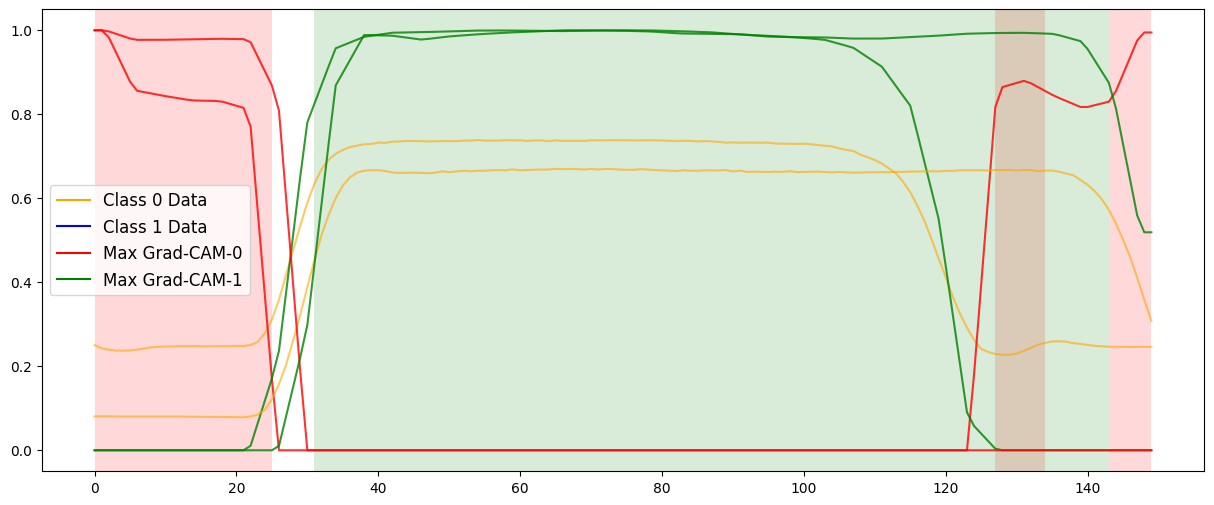

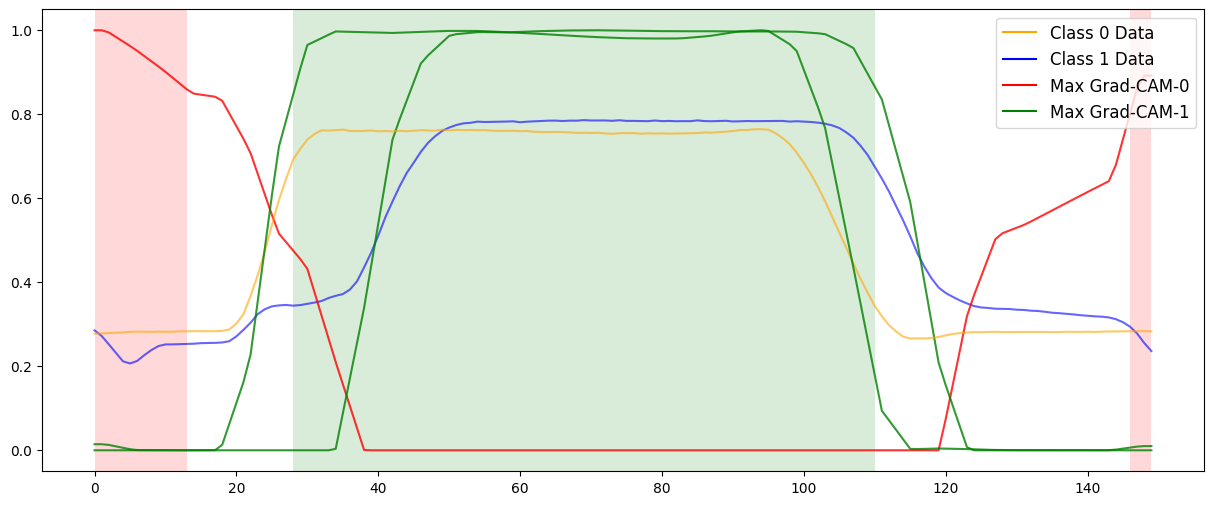

In [92]:
for x, y in [[train_x[6:8], train_y[6:8]], [test_x[6:8], test_y[6:8]]]:

    time_axis = np.arange(test_x.shape[1])
    plt.figure(figsize=(15, 6))

    # Initialize arrays for Grad-CAM maxima
    max_cam_0 = np.zeros_like(time_axis, dtype=float)
    max_cam_1 = np.zeros_like(time_axis, dtype=float)

    for i in range(len(x)):

        # Visualization
        color = 'blue' if y[i] == 1 else 'orange'
        plt.plot(time_axis, x[i], label="Input Time Series", color=color, alpha=0.6)

        # Compute Grad-CAM for class 0
        cam_0 = cnn_model.grad_cam(i, x, y, 0)
        max_cam_0 = np.fmax(max_cam_0, cam_0)
        plt.plot(time_axis, cam_0, alpha=0.8, label="Max Grad-CAM-0", color="red")

        # Compute Grad-CAM for class 1
        cam_1 = cnn_model.grad_cam(i, x, y, 1)
        max_cam_1 = np.fmax(max_cam_1, cam_1)
        plt.plot(time_axis, cam_1, alpha=0.8, label="Max Grad-CAM-1", color="green")


    # Add grey shaded areas where Grad-CAM max values exceed the threshold
    above_threshold_0 = max_cam_0 > threshold
    above_threshold_1 = max_cam_1 > threshold

    for i in range(1, len(time_axis)):
        if above_threshold_0[i]:
            plt.axvspan(time_axis[i - 1], time_axis[i], color='red', alpha=0.15, lw=0)

    for i in range(1, len(time_axis)):
        if above_threshold_1[i]:
            plt.axvspan(time_axis[i - 1], time_axis[i], color='green', alpha=0.15, lw=0)

    # Add title, labels, and legend
    # pltyormalized Value", fontdict = {'fontsize' : 14})

    colors = ['orange', 'blue', 'red', 'green']
    lines = [Line2D([0], [0], color=c) for c in colors]
    labels = ['Class 0 Data', 'Class 1 Data', 'Max Grad-CAM-0', 'Max Grad-CAM-1']
    plt.legend(lines, labels, prop={'size': 12})

    plt.show()


In [14]:
gunpoint_data = DataHandler(train_x, test_x, train_y, test_y)

In [112]:
mcnn_train_x, mcnn_test_x, mcnn_train_y, mcnn_test_y = gunpoint_data.getData(how="zero", all_areas=cnn_areas, invert=False)

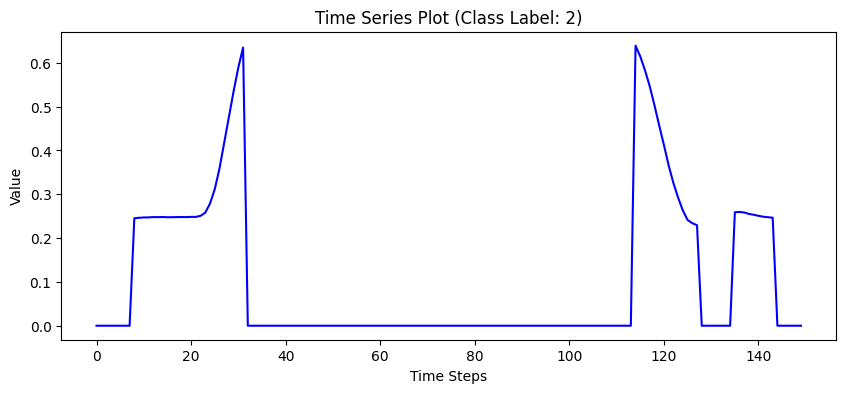

In [96]:
plot_ts([mcnn_train_x[6], mcnn_train_y[6]])

# LearningShapelets

In [100]:
avg_cnn_area_size = np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in cnn_areas for sample_areas in dataset_areas]) #### Average length of combined CNN areas
avg_cnn_area_size

53.355

In [102]:
number_shapelets = 3
shapelet_length = int(avg_cnn_area_size / number_shapelets)
shapelet_length

17

In [103]:
ls_model = LearningShapelets(n_shapelets_per_size={shapelet_length: number_shapelets}, scale=False)
ls_model.fit(train_x, train_y)

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(n_shapelets_per_size={17: 3})

In [104]:
ls_areas = []
for x, y in [[train_x, train_y], [test_x, test_y]]:
    ls_areas.append(getAreasFromLearningShapelets(ls_model.locate(x), ls_model.shapelets_))

In [116]:
mls_train_x, mls_test_x, mls_train_y, mls_test_y = gunpoint_data.getData(how="zero", all_areas=ls_areas, invert=False)

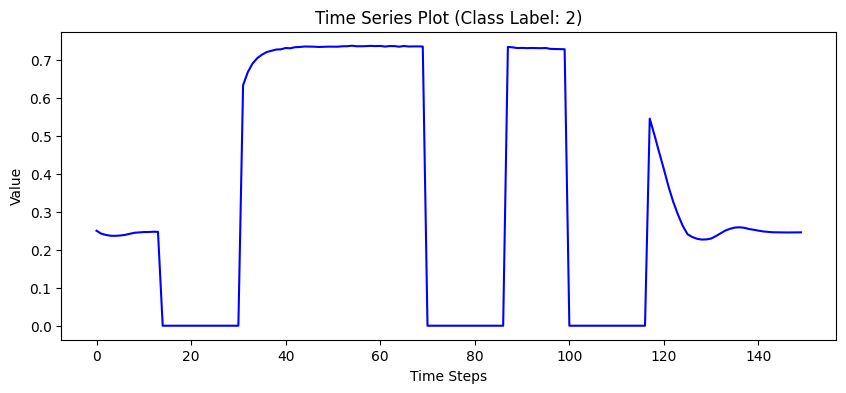

In [110]:
plot_ts([mls_train_x[6], mls_train_y[6]])

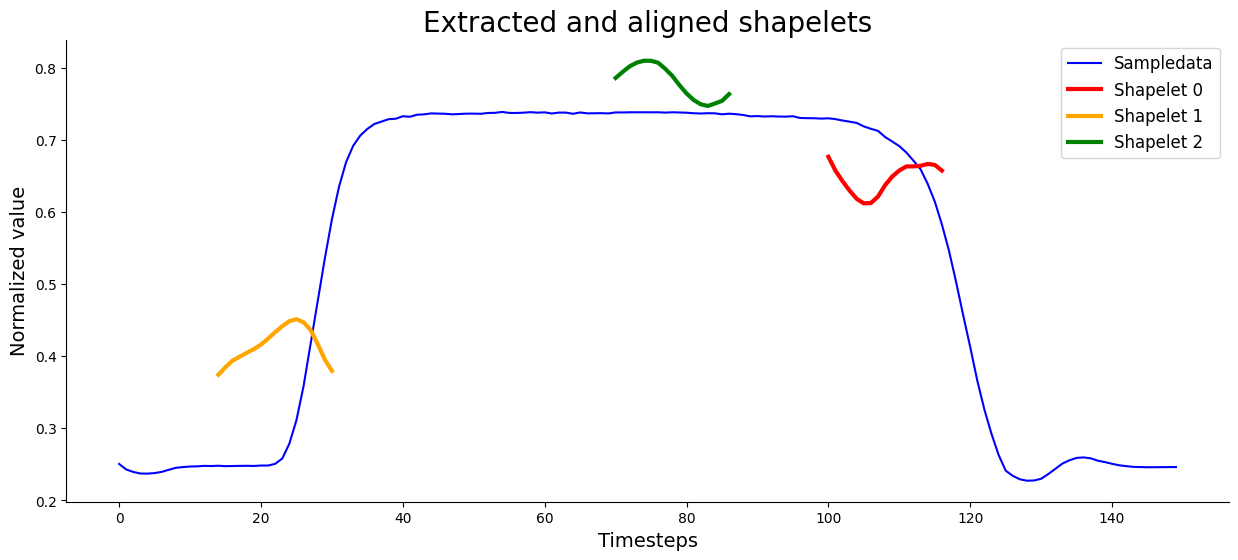

In [111]:
distances = ls_model.transform(train_x) # Do not use since distances come from blackbox model and are not the same as manually calculated distances
predicted_locations = ls_model.locate(train_x)

fig, ax = plt.subplots(figsize=(15, 6))

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.

test_ts_id = 6 #np.argmin(np.sum(distances, axis=1))
id_shap = 0

colors = ["red", "orange", "green", "black", "purple"]

ax.plot(train_x[test_ts_id].ravel(), color='blue', label="Sampledata")
for id_shap in range(len(ls_model.shapelets_)):
    shap = ls_model.shapelets_[id_shap]
    #shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
    pos = predicted_locations[test_ts_id, id_shap]
    ax.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color=colors[id_shap], label=f"Shapelet {id_shap}")
    # ax.axvline(pos, color='k', linestyle='--', alpha=0.25)

ax.set_ylabel("Normalized value", fontdict={'fontsize' : 14})
ax.set_xlabel("Timesteps", fontdict={'fontsize' : 14})
ax.set_title("Extracted and aligned shapelets", fontdict = {'fontsize' : 20})
ax.spines[['right', 'top']].set_visible(False)
ax.legend(prop={'size': 12})

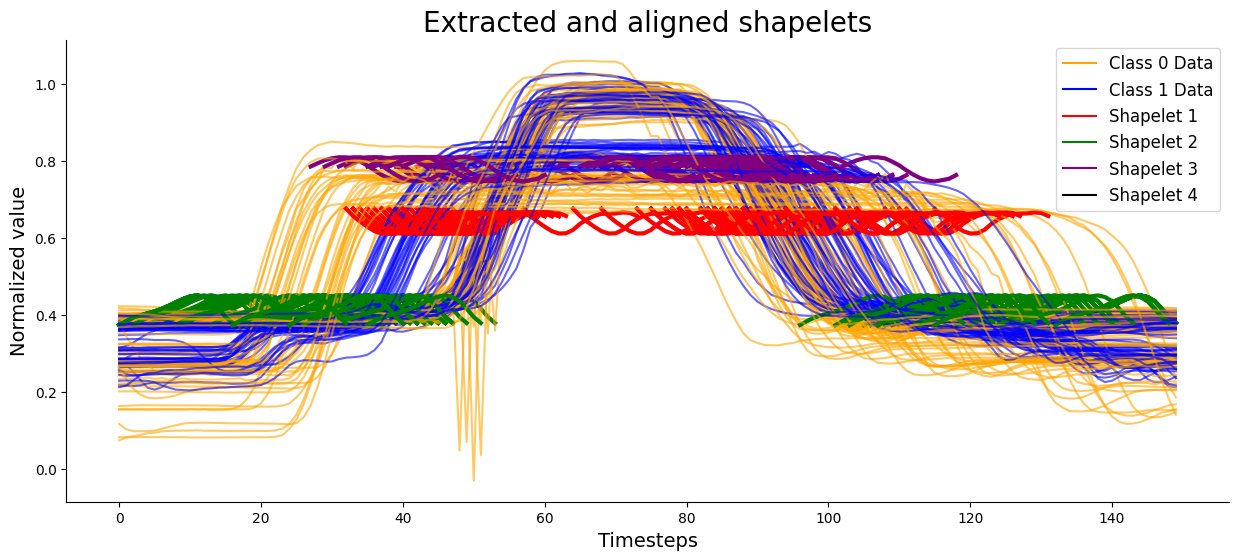

In [108]:
test_dataset = UCRDataset(test_x.astype(np.float32),test_y.astype(np.float32))
predicted_locations = ls_model.locate(test_x)

time_axis = np.arange(train_x.shape[1])
fig, ax = plt.subplots(figsize=(15, 6))

colors = ["red", "green", "purple", "black", "yellow"]

for test_ts_id in range(len(test_dataset)):
    input_tensor = test_dataset[test_ts_id][0]
    label = test_dataset[test_ts_id][1]

    # Visualization
    color = 'blue' if label == 1 else 'orange'
    ax.plot(time_axis, input_tensor, label="Input Time Series", color=color, alpha=0.6)

    for id_shap in range(len(ls_model.shapelets_)):
        shap = ls_model.shapelets_[id_shap]
        #shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
        pos = predicted_locations[test_ts_id, id_shap]
        ax.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color=colors[id_shap])

ax.set_ylabel("Normalized value", fontdict={'fontsize' : 14})
ax.set_xlabel("Timesteps", fontdict={'fontsize' : 14})
ax.set_title("Extracted and aligned shapelets", fontdict = {'fontsize' : 20})
ax.spines[['right', 'top']].set_visible(False)

colors = ['orange', 'blue', 'red', 'green', 'purple', 'black']
lines = [Line2D([0], [0], color=c) for c in colors]
labels = ['Class 0 Data', 'Class 1 Data', 'Shapelet 1', 'Shapelet 2', 'Shapelet 3', 'Shapelet 4']
plt.legend(lines, labels, prop={'size': 12})

# Evaluation

In [118]:
def getMeanConfidences(X):
    confidences = cnn_model.getConfidences(X)
    confidences0 = [confidence for confidence in confidences if confidence[0] > confidence[1]]
    confidences1 = [confidence for confidence in confidences if confidence[0] < confidence[1]]
    return np.mean([confidence[0] for confidence in confidences0]), len(confidences0), np.mean([confidence[1] for confidence in confidences1]), len(confidences1)


In [149]:
confidences = cnn_model.getConfidences(test_x)

confidences0 = [confidence for confidence in confidences if confidence[0] > confidence[1]]
confidences1 = [confidence for confidence in confidences if confidence[0] < confidence[1]]

np.mean([confidence[0] for confidence in confidences0])
np.mean([confidence[1] for confidence in confidences1])

0.9902562

In [122]:
getMeanConfidences(mls_train_x)

(0.9996958, 1, 0.99994135, 49)

In [133]:
mls_train_y

array([2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 1, 2])

In [150]:
cnn_model.test(test_x, test_y)

Test Accuracy: 94.67%


In [141]:
cnn_model.test(mcnn_train_x, mcnn_train_y)

Test Accuracy: 64.00%


In [131]:
cnn_model.classify(-1, train_x, train_y)

(1, 1)

In [159]:

float(sum(abs(confidences - cnn_model.enc.transform(mcnn_test_y.reshape(-1,1))))[0]) / len(mcnn_test_y)

0.0524473342399533

In [158]:
len(test_y)

150

In [164]:
def calculateConfidence(X, y):
    confidences = cnn_model.getConfidences(X)
    return 1 - (float(sum(abs(confidences - cnn_model.enc.transform(y.reshape(-1,1))))[0]) / len(y))

In [166]:
# The confidence of a dataset is 1 minus the average absolute deviation of the first one-hot encoded class and the corresponding probability given by the model
calculateConfidence(test_x, mls_test_y)

0.9475526657600467

# Validation Loop

Variables: 

-threshold for sizes of CNN-areas (number of areas automatically determined by grad-cam)

-number of shapelets (corresponding sizes are determined by size of CNN-areas)

-mode of cancellation (zero, linear or mean)

-inverted areas (true, false) --> can the areas determined as important alone cause good confidence levels?

Compare to original dataset as baseline

In [170]:
datasets = [{"name": "GunPoint", 1: "Gun", 2: "No Gun"}, 
            {"name": "Coffee", 0: "Robusta", 1: "Arabica"}]

In [174]:
thresholds = [0.9, 0.7, 0.5, 0.3, 0.1] ### higher threshold --> smaller areas
shapelet_numbers = [1, 2, 3, 4, 5]
modes_of_cancellation = ["zero", "linear", "mean"]
inverted = [False, True]

In [175]:
results = pd.DataFrame({"dataset": [], "threshold": [], "number_of_shapelets": [], "mode of cancellation": [], "inverted": [], "cnn_train_confidence": [], "cnn_test_confidence": [], "ls_train_confidence": [], "ls_test_confidence": []})

In [ ]:
# 1. Prepare Data
for dataset in datasets:

    train_x, test_x, train_y, test_y = fetch_ucr_dataset(dataset["name"], return_X_y = True)
    train_x, test_x = scale_dataset(train_x, test_x)

    data = DataHandler(train_x, test_x, train_y, test_y)


# 2. Train CNN
    train_x, test_x, train_y, test_y = data.getData("raw")
    cnn_model = ClassificationModel(train_x, train_y)
    cnn_model.fit(train_x, train_y, num_epochs=100)

    conftrain = calculateConfidence(train_x, train_y)
    conftest = calculateConfidence(test_x, test_y)

    results = pd.concat([results, pd.DataFrame({"dataset": [dataset["name"]], "threshold": [np.nan], "number_of_shapelets": [np.nan], "mode of cancellation": ["-"], "inverted": ["-"], "cnn_train_confidence": [conftrain], "cnn_test_confidence": [conftest], "ls_train_confidence": [conftrain], "ls_test_confidence": [conftest]})])

# 3. LearningShapelets Loop
    for threshold in thresholds:

        cnn_areas = []
        for x, y in [[train_x, train_y], [test_x, test_y]]:
            dataset_areas = []
            for i in range(len(x)):
                cam_0 = cnn_model.grad_cam(i, x, y, 0)
                cam_1 = cnn_model.grad_cam(i, x, y, 1)
                dataset_areas.append(getAreasFromGradCam(cam_0, cam_1, threshold))
            cnn_areas.append(dataset_areas)

        for shapelet_number in shapelet_numbers:
            
            avg_cnn_area_size = np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in cnn_areas for sample_areas in dataset_areas]) #### Average length of combined CNN areas
            shapelet_length = int(avg_cnn_area_size / number_shapelets)

            ls_model = LearningShapelets(n_shapelets_per_size={shapelet_length: number_shapelets}, scale=False)
            ls_model.fit(train_x, train_y)
            
            ls_areas = []
            for x, y in [[train_x, train_y], [test_x, test_y]]:
                ls_areas.append(getAreasFromLearningShapelets(ls_model.locate(x), ls_model.shapelets_))

# 4. Cancellation Loop
            for inv in inverted:
                for mode_of_cancellation in modes_of_cancellation:
                    
                    mcnn_train_x, mcnn_test_x, mcnn_train_y, mcnn_test_y = data.getData(how=mode_of_cancellation, all_areas=cnn_areas, invert=inv)
                    mls_train_x, mls_test_x, mls_train_y, mls_test_y = data.getData(how=mode_of_cancellation, all_areas=ls_areas, invert=inv)

                    confmcnntrain = calculateConfidence(mcnn_train_x, mcnn_train_y)
                    confmcnntest = calculateConfidence(mcnn_test_x, mcnn_test_y)
                    confmlstrain = calculateConfidence(mls_train_x, mls_train_y)
                    confmlstest = calculateConfidence(mls_test_x, mls_test_y)

                    results = pd.concat([results, pd.DataFrame({"dataset": [dataset["name"]], "threshold": [threshold], "number_of_shapelets": [number_shapelets], "mode of cancellation": [mode_of_cancellation], "inverted": [inv], "cnn_train_confidence": [confmcnntrain], "cnn_test_confidence": [confmcnntest], "ls_train_confidence": [confmlstrain], "ls_test_confidence": [confmlstest]})])
                    # print("loop")

# 5. Save results to file
results.to_csv("results.csv", header=True, index=False)

Epoch [1/100], Loss: 0.7001
Epoch [2/100], Loss: 0.6925
Epoch [3/100], Loss: 0.6940
Epoch [4/100], Loss: 0.6892
Epoch [5/100], Loss: 0.6893
Epoch [6/100], Loss: 0.7503
Epoch [7/100], Loss: 0.6969
Epoch [8/100], Loss: 0.6704
Epoch [9/100], Loss: 0.6207
Epoch [10/100], Loss: 0.5623
Epoch [11/100], Loss: 0.5345
Epoch [12/100], Loss: 0.4630
Epoch [13/100], Loss: 0.4797
Epoch [14/100], Loss: 0.4792
Epoch [15/100], Loss: 0.5076
Epoch [16/100], Loss: 0.4453
Epoch [17/100], Loss: 0.4510
Epoch [18/100], Loss: 0.4413
Epoch [19/100], Loss: 0.4697
Epoch [20/100], Loss: 0.4485
Epoch [21/100], Loss: 0.4454
Epoch [22/100], Loss: 0.4325
Epoch [23/100], Loss: 0.4252
Epoch [24/100], Loss: 0.4371
Epoch [25/100], Loss: 0.4522
Epoch [26/100], Loss: 0.4240
Epoch [27/100], Loss: 0.4341
Epoch [28/100], Loss: 0.4208
Epoch [29/100], Loss: 0.4065
Epoch [30/100], Loss: 0.4282
Epoch [31/100], Loss: 0.4223
Epoch [32/100], Loss: 0.4040
Epoch [33/100], Loss: 0.4329
Epoch [34/100], Loss: 0.4279
Epoch [35/100], Loss: 0

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


loop
loop
loop
loop
loop
loop


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


KeyboardInterrupt: 

In [178]:
results

,dataset,threshold,number_of_shapelets,mode of cancellation,inverted,cnn_train_confidence,cnn_test_confidence,ls_train_confidence,ls_test_confidence
0,GunPoint,NaN,NaN,-,NaN,0.999235,0.951761,0.999235,0.951761
0,GunPoint,0.9,3.0,zero,0.0,0.708330,0.592732,0.510616,0.528311
0,GunPoint,0.9,3.0,linear,False,0.999142,0.954103,0.999087,0.949963
0,GunPoint,0.9,3.0,mean,False,0.985511,0.943638,0.956011,0.876884
0,GunPoint,0.9,3.0,zero,True,0.439997,0.441748,0.520000,0.493333
0,GunPoint,0.9,3.0,linear,True,0.726211,0.578704,0.752973,0.819065
0,GunPoint,0.9,3.0,mean,True,0.638957,0.602990,0.481319,0.512913
